# 1. Model Architecture Overview

In [22]:
import torch
import torch.nn as nn

In [23]:
# torch.nn.Conv2d(in_channels, out_channels, kernel_size, padding=0)
conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
pool = nn.MaxPool2d(2)
fc = nn.Linear(3136, 10)

print(conv1)
print(conv2)
print(pool)
print(fc)

Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Linear(in_features=3136, out_features=10, bias=True)


In [24]:
# torch.Tensor(batch_size, channels, height, width)
inputs = torch.Tensor(1, 1, 28, 28)
out1 = conv1(inputs)
out2 = pool(out1)
out3 = conv2(out2)
out4 = pool(out3)
out5 = out4.view(out4.size(0), -1) 
out6 = fc(out5)

print(inputs.shape)
print(out1.shape)
print(out2.shape)
print(out3.shape)
print(out4.shape)
print(out5.shape)
print(out6.shape)

torch.Size([1, 1, 28, 28])
torch.Size([1, 32, 28, 28])
torch.Size([1, 32, 14, 14])
torch.Size([1, 64, 14, 14])
torch.Size([1, 64, 7, 7])
torch.Size([1, 3136])
torch.Size([1, 10])


---
# 2. Configure traning settings

In [10]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torch.nn.init

## 2-1. Set device

In [18]:
if torch.cuda.is_available():
    device = 'cuda'
    torch.cuda.manual_seed_all(777)
    print("Device set as 'CUDA'")
else:
    device = 'cpu'
    torch.manual_seed(777)
    print("Device set as 'CPU'")

Device set as 'CUDA'


### [TIP] Using GPU as hardware accelerator

[런타임] → [런타임 유형 변경] → [하드웨어 가속기] → [GPU] 선택

## 2-2. Define dataset & dataloader

In [19]:
mnist_train = dsets.MNIST(
    root='MNIST_data/',
    train=True,
    transform=transforms.ToTensor(),
    download=True)

mnist_test = dsets.MNIST(
    root='MNIST_data/',
    train=False,
    transform=transforms.ToTensor(),
    download=True)

data_loader = torch.utils.data.DataLoader(
    dataset=mnist_train,
    batch_size=100,
    shuffle=True,
    drop_last=True)

### [TIP] Visualizing data with numpy and matplotlib

Pytorch data `[batch_size, channel, width, height]`  
→ Image data `[width, height, channel]`

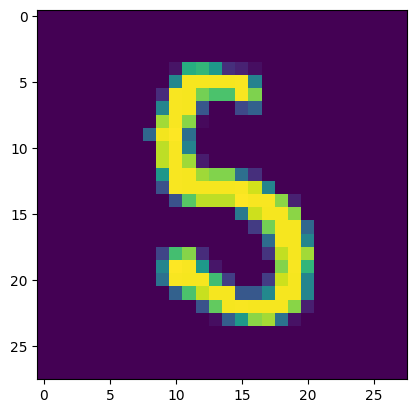

In [32]:
import matplotlib.pyplot as plt
import numpy as np

def custom_imshow(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))   # Convert Pytorch data to Image data format
    plt.show()

end_num = 1   # Number of images to print

for batch_idx, (inputs, targets) in enumerate(data_loader):   # Print 1 image per batch
    custom_imshow(inputs[0])
    if batch_idx == end_num-1:
        break

---
# 3. Simple CNN for MNIST

In [38]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)

        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [43]:
model = CNN().to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
learning_rate = 0.001
training_epochs = 2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
total_batch = len(data_loader)
print(f'Total batch count : {total_batch}')

Total batch count : 600


In [40]:
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 0.222223967
[Epoch:    2] cost = 0.0588997528


In [35]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Conv layer 1 :  torch.Size([10000, 32, 14, 14])
Conv layer 2 :  torch.Size([10000, 64, 7, 7])
Spread tensor :  torch.Size([10000, 3136])
FC layer :  torch.Size([10000, 10])
Accuracy: 0.9770999550819397


/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


---
# 4. Deep CNN for MNIST

In [45]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.keep_prob = 0.5

        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))
        
        self.fc1 = torch.nn.Linear(4 * 4 * 128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)

        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=1 - self.keep_prob))
        
        self.fc2 = torch.nn.Linear(625, 10, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.layer4(out)
        out = self.fc2(out)
        return out

In [47]:
model = CNN().to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
learning_rate = 0.001
training_epochs = 2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
total_batch = len(data_loader)
print(f'Total batch count : {total_batch}')

Total batch count : 600


In [48]:
for epoch in range(training_epochs):
    avg_cost = 0

    for X, Y in data_loader:
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

[Epoch:    1] cost = 0.189785197
[Epoch:    2] cost = 0.0544159897


In [49]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 0.9828999638557434


/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
